# Triplikat-analys

In [71]:
import pandas as pd
import numpy as np
import fragment_analyzer
from pathlib import Path
from natsort import natsorted
import altair as alt
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Data
### 3 för varje prov och PRT (triplikat)

In [167]:
data = natsorted([x for x in Path("demo/230316_triplets/").iterdir() if x.suffix == ".fsa"])

In [168]:
def prov(data: list, regex: int) -> list:
    regex = f"_{regex}[a|b|c]_"
    return natsorted([x for x in data if re.findall(regex, str(x))])

## Analys

### Dataframe

In [172]:
def analyze(
    files: list[Path],
    peak_model: str = "gauss",
    min_ratio: float = 0.2,
) -> pd.DataFrame:
    dfs = []
    for file in files:
        try:
            fsa = fragment_analyzer.FsaFile(file, "LIZ")
            pla = fragment_analyzer.PeakLadderAssigner(fsa)
            model = fragment_analyzer.FitLadderModel(pla)
            pam = fragment_analyzer.PeakAreaDeMultiplex(model, min_ratio=min_ratio)
            for i in pam:
                pam.fit_assay_peaks(peak_model, i)
                dfs.append(pam.assay_peak_area_df)
        except:
            print(f"ERROR: {file}")
        
    df = pd.concat(dfs).reset_index(drop=True)
    return (
        df
        .assign(PRT=lambda x: x.file_name.str.extract(r"(PRT[0-9])"))
    )
        

In [233]:
prover = prov(data, 3)
prov_df = analyze(prover)

2 peaks found in PRT1_3a__442_C01.fsa
1 assays in PRT1_3a__442_C01.fsa
2 peaks found in PRT1_3b__442_C02.fsa
1 assays in PRT1_3b__442_C02.fsa
2 peaks found in PRT1_3c__442_C03.fsa
1 assays in PRT1_3c__442_C03.fsa
2 peaks found in PRT2_3a__442_C04.fsa
1 assays in PRT2_3a__442_C04.fsa
2 peaks found in PRT2_3b__442_C05.fsa
1 assays in PRT2_3b__442_C05.fsa
2 peaks found in PRT2_3c__442_C06.fsa
1 assays in PRT2_3c__442_C06.fsa
2 peaks found in PRT3_3a__442_C07.fsa
1 assays in PRT3_3a__442_C07.fsa
2 peaks found in PRT3_3b__442_C08.fsa
1 assays in PRT3_3b__442_C08.fsa
2 peaks found in PRT3_3c__442_C09.fsa
1 assays in PRT3_3c__442_C09.fsa
5 peaks found in PRT4_3a__442_C10.fsa
1 assays in PRT4_3a__442_C10.fsa
5 peaks found in PRT4_3b__442_C11.fsa
1 assays in PRT4_3b__442_C11.fsa
ERROR: demo/230316_triplets/PRT4_3c__442_C12.fsa


In [212]:
# dåliga prov
# PRT4_3c__442_C12.fsa
# PRT2_4b__442_D05.fsa 

# TODO
# Titta på 8a
# gör om 3an

In [252]:
#prov_df.to_csv("triplet-analysis/prov3/prov3.csv", index=False)

## Plotting 

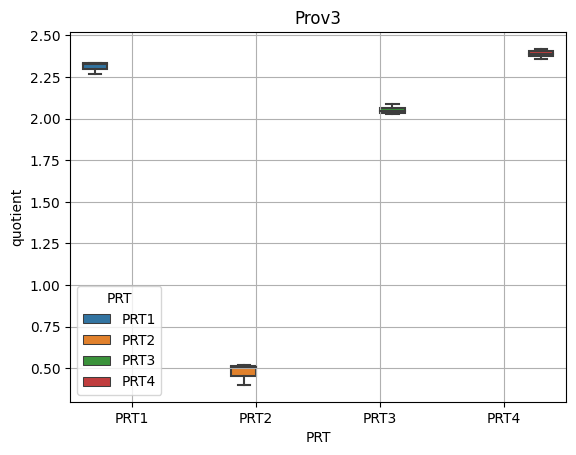

In [255]:
def boxplot(df: pd.DataFrame, sample_name):
    df = df.drop_duplicates(subset="quotient")
    
    fig = sns.boxplot(data=df, x="PRT", y="quotient", hue="PRT").set_title(sample_name)
    plt.grid()
    
    return fig.get_figure()

fig = boxplot(prov_df, "Prov3")

fig.savefig("triplet-analysis/prov3/prov3.pdf")

In [79]:
df = pd.concat([pd.read_csv(x) for x in Path("triplet-analysis/").rglob("*.csv") if "ipynb" not in str(x)])

In [81]:
df = (
    df
    .groupby(["file_name", "PRT"])
    .first("quotient")
    .reset_index()
    .assign(sample_name=lambda x: x.file_name.str.extract(r"PRT[1-4]_([1-9])").astype(int))
    # inverse the quotient number for PRT1
    #.assign(quotient=lambda x:
    #        np.select(
    #            [x.PRT == "PRT1"],
    #            [1 / x.quotient],
    #            default=x.quotient
    #        )
    #)
    # filter out too small values (8a)
)



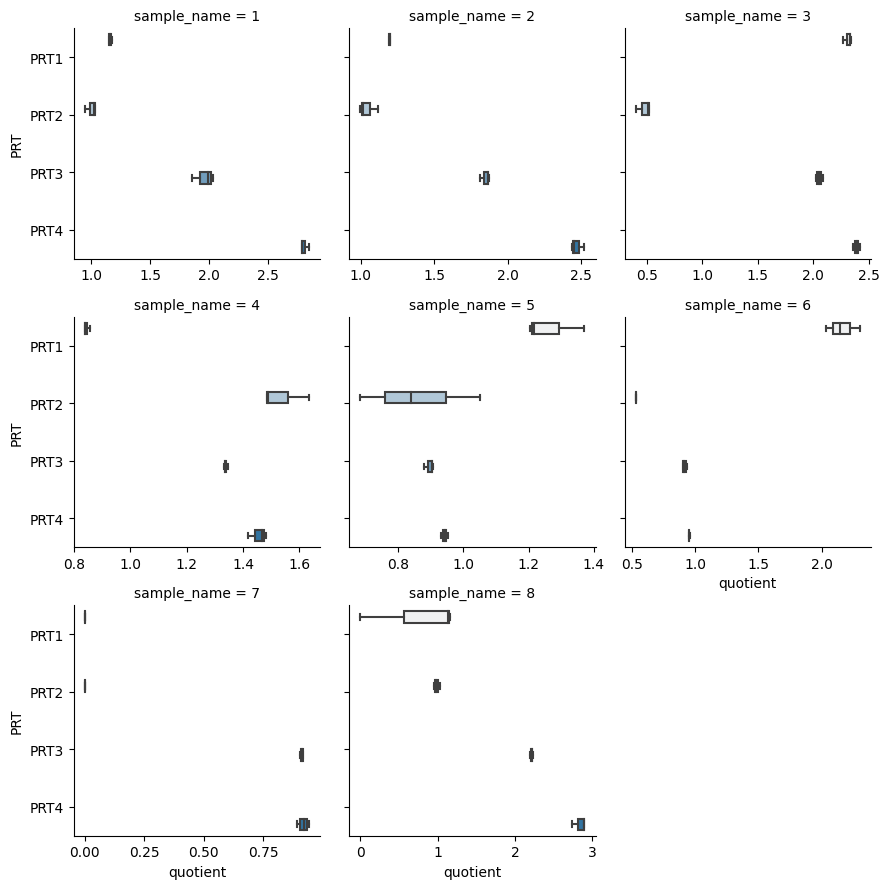

In [82]:
g = sns.FacetGrid(df, col="sample_name", col_wrap=3, sharex=False)
g = g.map_dataframe(sns.boxplot, x="quotient", y="PRT", hue="PRT")
#g.savefig("triplet-analysis/facetgrid.pdf")